In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
path = "../data/raw/hr.csv"
df = pd.read_csv(path)

In [ ]:
def eda_revision_completa(df):
    """
    Realiza una revisión exploratoria estructurada del DataFrame con foco en:

    1. Visión general del dataset (dimensiones y duplicados)
    2. Calidad de columnas (tipos, nulos, cardinalidad)
    3. Análisis detallado de nulos:
        - Variables categóricas con nulos:
            * % de nulos visible en el encabezado
            * Distribución porcentual y recuento de categorías
        - Variables numéricas con nulos:
            * % de nulos visible en el encabezado
            * Distribución porcentual y recuento de valores
            * Histogramas
    4. Estadísticas descriptivas:
        - Describe de variables numéricas
        - Describe de variables categóricas
    5. Detección de outliers (IQR)
    6. Correlaciones entre variables numéricas
    7. Alertas estructurales (constantes, casi constantes, posibles IDs)
    8. Detección de variables que comparten una escala ordinal común
       y sugerencia de mapeo semántico

    El objetivo es facilitar decisiones de limpieza, imputación
    y entendimiento del dataset antes de modelar.
    """

    filas, columnas = df.shape

    # ==================================================
    # 1. VISIÓN GENERAL
    # ==================================================
    print("📐 VISIÓN GENERAL DEL DATASET")
    print(f"Filas: {filas} | Columnas: {columnas}")
    duplicados = df.duplicated().sum()
    print(f"Filas duplicadas: {duplicados} ({duplicados/filas*100:.2f}%)")
    print("-"*70)

    # ==================================================
    # 2. CALIDAD DE COLUMNAS
    # ==================================================
    print("🚑 CALIDAD DE COLUMNAS")
    calidad = pd.DataFrame({
        "Tipo": df.dtypes,
        "Nulos": df.isnull().sum(),
        "% Nulos": (df.isnull().mean()*100).round(2),
        "Valores Únicos": df.nunique(),
        "% Cardinalidad": (df.nunique()/filas*100).round(2)
    }).sort_values("% Nulos", ascending=False)

    display(calidad)

    # ==================================================
    # 3. NULOS – VARIABLES CATEGÓRICAS
    # ==================================================
    cols_cat = df.select_dtypes(include=["object", "category"]).columns
    cols_cat_nulos = [c for c in cols_cat if df[c].isnull().any()]

    print("\n🔤 NULOS EN VARIABLES CATEGÓRICAS")
    if cols_cat_nulos:
        for col in cols_cat_nulos:
            pct_nulos = df[col].isnull().mean() * 100
            print(f"\n📌 {col} (Nulos: {pct_nulos:.2f}%)")

            dist_pct = df[col].value_counts(normalize=True, dropna=False) * 100
            dist_cnt = df[col].value_counts(dropna=False)

            display(pd.DataFrame({
                "Porcentaje": dist_pct.round(2),
                "Recuento": dist_cnt
            }))
    else:
        print("No hay variables categóricas con nulos.")

    # ==================================================
    # 4. NULOS – VARIABLES NUMÉRICAS
    # ==================================================
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    cols_num_nulos = [c for c in num_cols if df[c].isnull().any()]

    print("\n📊 NULOS EN VARIABLES NUMÉRICAS")
    if cols_num_nulos:
        for col in cols_num_nulos:
            pct_nulos = df[col].isnull().mean() * 100
            print(f"\n📌 {col} (Nulos: {pct_nulos:.2f}%)")

            dist_pct = df[col].value_counts(normalize=True, dropna=False) * 100
            dist_cnt = df[col].value_counts(dropna=False)

            display(pd.DataFrame({
                "Porcentaje": dist_pct.round(2),
                "Recuento": dist_cnt
            }))

            # Histograma
            plt.figure()
            df[col].hist(bins=30)
            plt.title(f"Histograma de {col}")
            plt.xlabel(col)
            plt.ylabel("Frecuencia")
            plt.show()
    else:
        print("No hay variables numéricas con nulos.")

    # ==================================================
    # 5. ESTADÍSTICAS DESCRIPTIVAS
    # ==================================================
    print("\n📊 DESCRIBE VARIABLES NUMÉRICAS")
    if len(num_cols) > 0:
        display(df[num_cols].describe().T)

    print("\n🔤 DESCRIBE VARIABLES CATEGÓRICAS")
    if len(cols_cat) > 0:
        display(df[cols_cat].describe().T)

    print("\n📝 ANÁLISIS DE CATEGORÍAS ÚNICAS DE TODAS LAS VARIABLES OBJECT")
    cols_cat = df.select_dtypes(include=["object", "category"]).columns

    for col in cols_cat:
        print(f"\n📌 {col} - Categorías actuales ({df[col].nunique()} únicas):")
        display(pd.DataFrame(df[col].unique(), columns=['Valor único']))

    # ==================================================
    # 6. DETECCIÓN DE OUTLIERS (IQR)
    # ==================================================
    print("\n⚠️ DETECCIÓN DE OUTLIERS (IQR 1.5x)")
    for col in num_cols:
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        outliers = ((df[col] < Q1 - 1.5*IQR) |
                    (df[col] > Q3 + 1.5*IQR)).sum()
        if outliers > 0:
            print(f"- {col}: {outliers} outliers ({outliers/filas*100:.2f}%)")

    # ==================================================
    # 7. CORRELACIONES
    # ==================================================
    print("\n🔗 CORRELACIONES ENTRE VARIABLES NUMÉRICAS")
    if len(num_cols) > 1:
        corr = df[num_cols].corr()
        display(corr)

        high_corr = (
            corr.abs()
            .where(np.triu(np.ones(corr.shape), k=1).astype(bool))
            .stack()
            .sort_values(ascending=False)
        )

        if not high_corr.empty:
            print("\n⚠️ Correlaciones altas (>0.8)")
            display(high_corr[high_corr > 0.8])

    # ==================================================
    # 8. ALERTAS ESTRUCTURALES
    # ==================================================
    print("\n🚨 ALERTAS ESTRUCTURALES")

    constantes = calidad[calidad["Valores Únicos"] == 1].index.tolist()
    if constantes:
        print(f"⚠️ Columnas constantes: {constantes}")

    casi_constantes = []
    for col in df.columns:
        vc = df[col].value_counts(normalize=True, dropna=False)
        if not vc.empty and vc.iloc[0] > 0.95:
            casi_constantes.append(col)

    if casi_constantes:
        print(f"⚠️ Columnas casi constantes (>95% mismo valor): {casi_constantes}")

    posibles_ids = calidad[calidad["% Cardinalidad"] > 95].index.tolist()
    if posibles_ids:
        print(f"🆔 Posibles IDs o identificadores: {posibles_ids}")

    # ==================================================
    # 9. ESCALAS ORDINALES COMPARTIDAS
    # ==================================================
    print("\n💡 DETECCIÓN DE ESCALAS ORDINALES COMPARTIDAS")

    escala_comun = {
        1: "Nada satisfecho",
        2: "Insatisfecho",
        3: "Satisfecho",
        4: "Muy Satisfecho"
    }

    cols_ordinales = [
        col for col in num_cols
        if set(df[col].dropna().unique()).issubset(set(escala_comun.keys()))
    ]

    if cols_ordinales:
        print(f"Columnas que siguen la misma escala: {cols_ordinales}")
        print("Escala sugerida:")
        for k, v in escala_comun.items():
            print(f"{k} → {v}")
    else:
        print("No se detectaron columnas con la escala ordinal definida.")

    print("\n🏁 REVISIÓN EDA FINALIZADA")

📐 VISIÓN GENERAL DEL DATASET
Filas: 1474 | Columnas: 35
Filas duplicadas: 4 (0.27%)
----------------------------------------------------------------------
🚑 CALIDAD DE COLUMNAS


,Tipo,Nulos,% Nulos,Valores Únicos,% Cardinalidad
StandardHours,float64,164,11.13,1,0.07
YearsWithCurrManager,float64,148,10.04,18,1.22
MaritalStatus,object,132,8.96,4,0.27
BusinessTravel,object,117,7.94,3,0.20
TrainingTimesLastYear,float64,88,5.97,7,0.47
Age,float64,73,4.95,43,2.92
EducationField,object,58,3.93,6,0.41
OverTime,object,44,2.99,2,0.14
JobSatisfaction,float64,29,1.97,4,0.27
Department,object,29,1.97,3,0.20



🔤 NULOS EN VARIABLES CATEGÓRICAS

📌 BusinessTravel (Nulos: 7.94%)


,Porcentaje,Recuento
BusinessTravel,,
Travel_Rarely,64.79,955
Travel_Frequently,17.84,263
Non-Travel,9.43,139
NaN,7.94,117



📌 Department (Nulos: 1.97%)


,Porcentaje,Recuento
Department,,
Research & Development,63.84,941
Sales,29.85,440
Human Resources,4.34,64
NaN,1.97,29



📌 EducationField (Nulos: 3.93%)


,Porcentaje,Recuento
EducationField,,
Life Sciences,39.48,582
Medical,30.46,449
Marketing,10.31,152
Technical Degree,8.82,130
Other,5.36,79
NaN,3.93,58
Human Resources,1.63,24



📌 MaritalStatus (Nulos: 8.96%)


,Porcentaje,Recuento
MaritalStatus,,
Married,40.98,604
Single,29.65,437
Divorced,20.22,298
NaN,8.96,132
Marreid,0.20,3



📌 OverTime (Nulos: 2.99%)


,Porcentaje,Recuento
OverTime,,
No,69.54,1025
Yes,27.48,405
NaN,2.99,44



📊 NULOS EN VARIABLES NUMÉRICAS

📌 Age (Nulos: 4.95%)


,Porcentaje,Recuento
Age,,
35.0,4.95,73
NaN,4.95,73
34.0,4.88,72
36.0,4.61,68
29.0,4.41,65
31.0,4.27,63
32.0,4.00,59
30.0,3.87,57
33.0,3.87,57


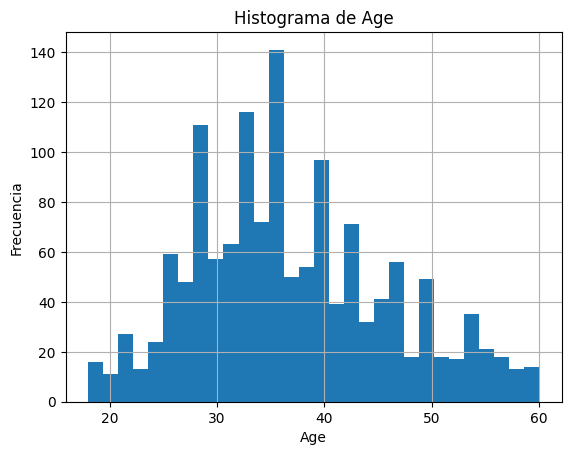


📌 JobSatisfaction (Nulos: 1.97%)


,Porcentaje,Recuento
JobSatisfaction,,
4.0,30.87,455
3.0,29.10,429
1.0,19.40,286
2.0,18.66,275
NaN,1.97,29


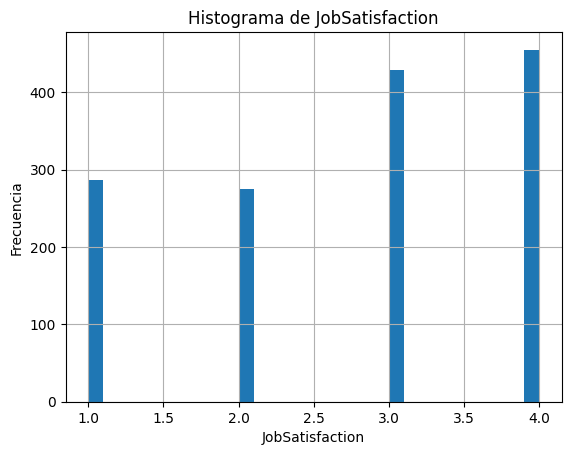


📌 MonthlyIncome (Nulos: 0.95%)


,Porcentaje,Recuento
MonthlyIncome,,
NaN,0.95,14
2342.0,0.27,4
2451.0,0.20,3
2404.0,0.20,3
2380.0,0.20,3
...,...,...
13570.0,0.07,1
6712.0,0.07,1
5406.0,0.07,1


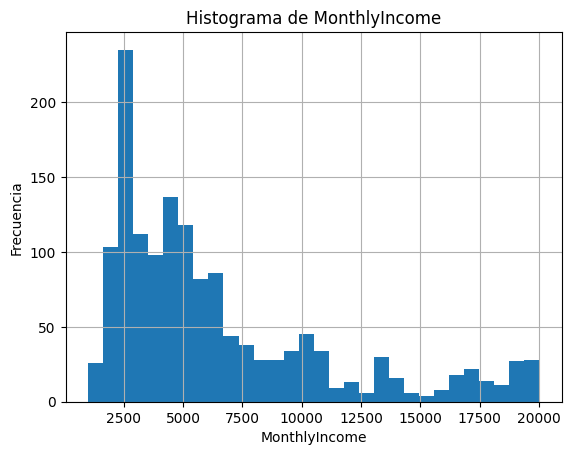


📌 StandardHours (Nulos: 11.13%)


,Porcentaje,Recuento
StandardHours,,
80.0,88.87,1310
NaN,11.13,164


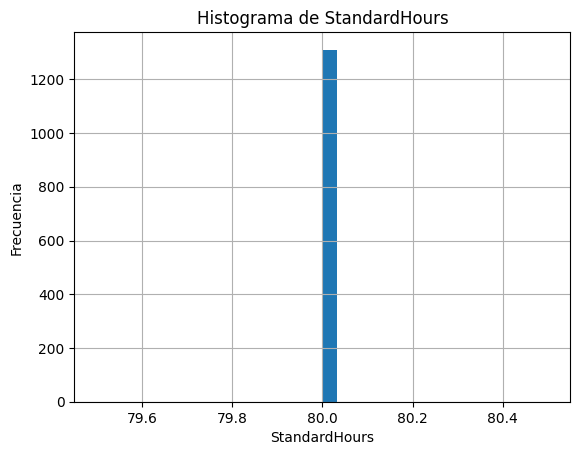


📌 TrainingTimesLastYear (Nulos: 5.97%)


,Porcentaje,Recuento
TrainingTimesLastYear,,
2.0,35.28,520
3.0,30.94,456
4.0,8.01,118
5.0,7.53,111
NaN,5.97,88
1.0,4.41,65
6.0,4.27,63
0.0,3.60,53


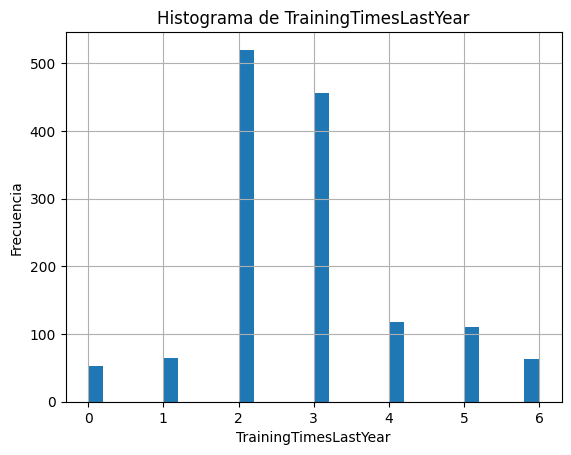


📌 YearsWithCurrManager (Nulos: 10.04%)


,Porcentaje,Recuento
YearsWithCurrManager,,
2.0,21.85,322
0.0,16.01,236
7.0,13.16,194
NaN,10.04,148
3.0,8.41,124
8.0,6.72,99
4.0,6.04,89
1.0,4.68,69
9.0,3.73,55


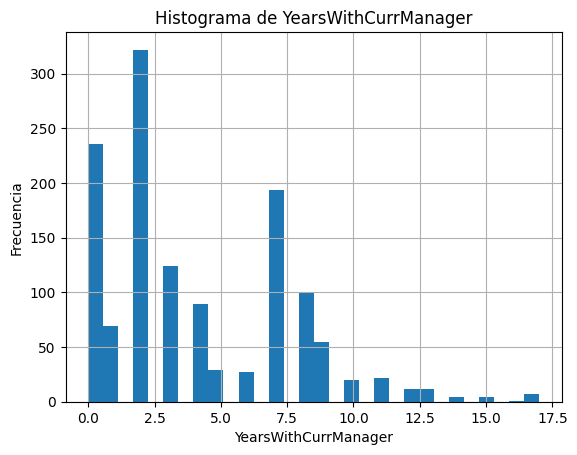


📊 DESCRIBE VARIABLES NUMÉRICAS


,count,mean,std,min,25%,50%,75%,max
Age,1401.0,36.944325,9.105009,18.0,30.00,36.0,43.00,60.0
DailyRate,1474.0,802.702171,403.539530,102.0,465.00,803.0,1157.00,1499.0
DistanceFromHome,1474.0,9.199457,8.104266,1.0,2.00,7.0,14.00,29.0
Education,1474.0,2.911126,1.024267,1.0,2.00,3.0,4.00,5.0
EmployeeCount,1474.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
EmployeeNumber,1474.0,1024.471506,602.421193,1.0,488.75,1020.5,1555.75,2068.0
EnvironmentSatisfaction,1474.0,2.723881,1.093280,1.0,2.00,3.0,4.00,4.0
HourlyRate,1474.0,65.887381,20.310444,30.0,48.00,66.0,83.75,100.0
JobInvolvement,1474.0,2.729986,0.712861,1.0,2.00,3.0,3.00,4.0
JobLevel,1474.0,2.063772,1.106055,1.0,1.00,2.0,3.00,5.0



🔤 DESCRIBE VARIABLES CATEGÓRICAS


,count,unique,top,freq
Attrition,1474,2,No,1236
BusinessTravel,1357,3,Travel_Rarely,955
Department,1445,3,Research & Development,941
EducationField,1416,6,Life Sciences,582
Gender,1474,2,Male,885
JobRole,1474,9,sALES eXECUTIVE,327
MaritalStatus,1342,4,Married,604
Over18,1474,1,Y,1474
OverTime,1430,2,No,1025



📝 ANÁLISIS DE CATEGORÍAS ÚNICAS DE TODAS LAS VARIABLES OBJECT

📌 Attrition - Categorías actuales (2 únicas):


,Valor único
0,Yes
1,No



📌 BusinessTravel - Categorías actuales (3 únicas):


,Valor único
0,Travel_Rarely
1,Travel_Frequently
2,Non-Travel
3,NaN



📌 Department - Categorías actuales (3 únicas):


,Valor único
0,Sales
1,Research & Development
2,NaN
3,Human Resources



📌 EducationField - Categorías actuales (6 únicas):


,Valor único
0,Life Sciences
1,Other
2,Medical
3,NaN
4,Marketing
5,Technical Degree
6,Human Resources



📌 Gender - Categorías actuales (2 únicas):


,Valor único
0,Female
1,Male



📌 JobRole - Categorías actuales (9 únicas):


,Valor único
0,sALES eXECUTIVE
1,rESEARCH sCIENTIST
2,lABORATORY tECHNICIAN
3,mANUFACTURING dIRECTOR
4,hEALTHCARE rEPRESENTATIVE
5,mANAGER
6,sALES rEPRESENTATIVE
7,rESEARCH dIRECTOR
8,hUMAN rESOURCES



📌 MaritalStatus - Categorías actuales (4 únicas):


,Valor único
0,Single
1,Married
2,Divorced
3,NaN
4,Marreid



📌 Over18 - Categorías actuales (1 únicas):


,Valor único
0,Y



📌 OverTime - Categorías actuales (2 únicas):


,Valor único
0,Yes
1,No
2,NaN



⚠️ DETECCIÓN DE OUTLIERS (IQR 1.5x)
- MonthlyIncome: 113 outliers (7.67%)
- NumCompaniesWorked: 52 outliers (3.53%)
- PerformanceRating: 226 outliers (15.33%)
- StockOptionLevel: 85 outliers (5.77%)
- TotalWorkingYears: 63 outliers (4.27%)
- TrainingTimesLastYear: 227 outliers (15.40%)
- YearsAtCompany: 104 outliers (7.06%)
- YearsInCurrentRole: 21 outliers (1.42%)
- YearsSinceLastPromotion: 107 outliers (7.26%)
- YearsWithCurrManager: 12 outliers (0.81%)

🔗 CORRELACIONES ENTRE VARIABLES NUMÉRICAS


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,0.012928,-0.003047,0.197619,NaN,-0.015103,0.011139,0.019332,0.021280,0.504765,...,0.038351,NaN,0.040620,0.673863,-0.027412,-0.020006,0.298187,0.205234,0.203265,0.207117
DailyRate,0.012928,1.000000,-0.006546,-0.015326,NaN,-0.053834,0.017276,0.023287,0.049445,0.004601,...,0.008072,NaN,0.042600,0.016850,0.021125,-0.037607,-0.034204,0.009661,-0.033352,-0.042303
DistanceFromHome,-0.003047,-0.006546,1.000000,0.018657,NaN,0.033661,-0.014698,0.030278,0.006508,0.004109,...,0.006449,NaN,0.045773,0.002856,-0.033384,-0.026235,0.008578,0.017595,0.009423,0.023442
Education,0.197619,-0.015326,0.018657,1.000000,NaN,0.041203,-0.029204,0.017532,0.044284,0.102684,...,-0.009512,NaN,0.017174,0.149987,-0.032528,0.009210,0.070422,0.061863,0.055175,0.074195
EmployeeCount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeNumber,-0.015103,-0.053834,0.033661,0.041203,NaN,1.000000,0.018730,0.035979,-0.010504,-0.020093,...,-0.069392,NaN,0.060268,-0.016833,0.025670,0.010066,-0.010669,-0.007557,-0.008669,-0.012592
EnvironmentSatisfaction,0.011139,0.017276,-0.014698,-0.029204,NaN,0.018730,1.000000,-0.049555,-0.008620,-0.000025,...,0.008896,NaN,0.003890,-0.005698,-0.027620,0.028233,0.000468,0.017023,0.015344,0.000214
HourlyRate,0.019332,0.023287,0.030278,0.017532,NaN,0.035979,-0.049555,1.000000,0.042959,-0.027785,...,0.001840,NaN,0.049087,-0.002557,-0.010716,-0.004667,-0.019126,-0.023349,-0.026472,-0.036795
JobInvolvement,0.021280,0.049445,0.006508,0.044284,NaN,-0.010504,-0.008620,0.042959,1.000000,-0.010865,...,0.034427,NaN,0.022569,-0.004026,-0.004510,-0.014542,-0.020585,0.009543,-0.023694,0.019918
JobLevel,0.504765,0.004601,0.004109,0.102684,NaN,-0.020093,-0.000025,-0.027785,-0.010865,1.000000,...,0.021539,NaN,0.013924,0.782120,-0.017410,0.037738,0.534136,0.388937,0.353626,0.373210



⚠️ Correlaciones altas (>0.8)


JobLevel  MonthlyIncome    0.950176
dtype: float64


🚨 ALERTAS ESTRUCTURALES
⚠️ Columnas constantes: ['StandardHours', 'EmployeeCount', 'Over18']
⚠️ Columnas casi constantes (>95% mismo valor): ['EmployeeCount', 'Over18']
🆔 Posibles IDs o identificadores: ['EmployeeNumber', 'MonthlyRate']

💡 DETECCIÓN DE ESCALAS ORDINALES COMPARTIDAS
Columnas que siguen la misma escala: ['EmployeeCount', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']
Escala sugerida:
1 → Muy Insatisfecho
2 → Insatisfecho
3 → Satisfecho
4 → Muy Satisfecho

🏁 REVISIÓN EDA FINALIZADA


In [8]:
eda_revision_completa(df)

## 🧹 Decisiones de limpieza de datos

A continuación se documentan las decisiones de limpieza adoptadas tras la revisión exploratoria del dataset, con el objetivo de mejorar la calidad de los datos y facilitar su uso en etapas posteriores de análisis y modelado.

---

### 📌 0. Visión general del dataset

Se realizó una inspección inicial del dataset para entender su estructura y posibles problemas:

- **Filas**: 1474  
- **Columnas**: 35  
- **Filas duplicadas**: 4 (0.27%)

Esta visión permitió identificar duplicados, tipos de datos incorrectos y columnas con problemas de consistencia que se tratan en los apartados siguientes.

---

### 🗑 1. Eliminación de filas duplicadas

- Se identificaron **4 filas duplicadas**, lo que representa aproximadamente **el 0.27% del total del dataset**.
- Dado que los duplicados no aportan información adicional y pueden introducir sesgos en análisis estadísticos y modelos predictivos, **se decidió eliminar todas las filas duplicadas**.

**Acción**:  
- Eliminar duplicados usando `df.drop_duplicates()`.

---

### 🧾 2. Revisión de la calidad de las columnas y cambio de tipos

Se evaluaron **tipos de datos, nulos y cardinalidad** para cada columna y se identificaron los siguientes cambios de tipo o estandarización:

- **Age** → `int64`  
- **DailyRate, HourlyRate, MonthlyRate** → `float`  
- **JobSatisfaction, TrainingTimesLastYear, YearsAtCompany, YearsInCurrentRole, YearsSinceLastPromotion, YearsWithCurrentManager** → `int64`  
- **BusinessTravel, Department, EducationField, Gender, Attrition, OverTime, MaritalStatus, JobRole** → categóricas  
- **Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, PerformanceRating, RelationshipSatisfaction, StockOptionLevel, WorkLifeBalance** → ordinal  

---

### 💬 3. Tratamiento de valores nulos en variables categóricas

- Variables afectadas: `BusinessTravel`, `Department`, `EducationField`, `JobRole`, `Gender`, `MaritalStatus`, `OverTime`  
- Para cada variable se analizaron porcentaje de nulos y distribución de categorías.  
- **Decisión**:  
  - Cuando el porcentaje de nulos es bajo y existe una categoría dominante: imputar con la moda  
  - Cuando los nulos representan un grupo relevante o semánticamente distinto: crear categoría explícita `"Missing"` o `"Unknown"`  

---

### 🔢 4. Tratamiento de valores nulos en variables numéricas

- Variables afectadas: `TrainingTimesLastYear`, `NumCompaniesWorked`, `TotalWorkingYears` (si aplica)  
- Se evaluó porcentaje de nulos y distribución de valores.  
- **Decisión**:  
  - Si el porcentaje de nulos es bajo: imputación con medidas robustas (mediana)  
  - Si el porcentaje es elevado: evaluar eliminación de la variable o creación de una variable indicadora de missingness  

---

### ✍️ 5. Normalización y corrección de columnas categóricas

Durante el análisis de categorías únicas se detectaron inconsistencias en la escritura y formato de texto, así como errores tipográficos.  
Se propone la siguiente normalización y homogenización, **sin considerar aún los valores nulos**:

- **BusinessTravel**  
  - Observación: valores consistentes (`Travel_Rarely`, `Travel_Frequently`, `Non-Travel`).  
  - Acción: homogeneizar usando `Title Case` y eliminar espacios innecesarios. Pasar a escala (`Rarely`, `Frequently`, `Non`).  

- **JobRole**  
  - Observación: las categorías presentan inconsistencias en mayúsculas/minúsculas (`sALES eXECUTIVE`, `rESEARCH sCIENTIST`, etc.) y posibles espacios extra.  
  - Acción: normalizar todos los valores a formato `Title Case` y eliminar espacios al inicio o final.  

- **MaritalStatus**  
  - Observación: error tipográfico detectado (`Marreid`), además de inconsistencias en mayúsculas/minúsculas.  
  - Acción: corregir typo a `Married` y homogeneizar formato con `Title Case`.  

---

### 🚫 6. Columnas constantes o de alta cardinalidad

- Columnas **constantes** eliminadas: `EmployeeCount`, `Over18`, `StandardHours`  
- Columnas con **alta cardinalidad (>95%)** eliminadas: `MonthlyRate` (excluida del análisis predictivo)  

---

### 🆔 7. Variables identificadas como posibles IDs

- `EmployeeNumber` se establece como **índice del DataFrame** y se excluye de los modelos predictivos.

---

### ⚠️ 8. Detección y tratamiento de outliers en variables numéricas

- Se utilizaron criterios de **IQR (1.5x)** para detectar outliers.  
- Ejemplos de detección por variable (valores extremos detectados):  
  - `DailyRate`: valores <100 o >1400  
  - `MonthlyIncome`: valores >17000  
  - `DistanceFromHome`: valores extremos en 1 y 29 km  

**Decisión**:  
- Mantener outliers si porcentaje bajo  
- Considerar transformaciones o winsorización si porcentaje alto

---

### 🔗 9. Análisis de correlación entre variables numéricas

- Se detectaron pares de variables altamente correlacionadas (r > 0.8), que podrían ser redundantes.  
- **Decisión**: evaluar eliminación o combinación priorizando interpretabilidad y estabilidad del modelo.

---

### 📊 10. Escalas ordinales compartidas y mapeo de encuestas

Se identificaron variables que utilizan la misma escala ordinal (1 a 4) para encuestas internas:

- `EnvironmentSatisfaction`  
- `JobSatisfaction`  
- `WorkLifeBalance`  
- `JobInvolvement`  
- `RelationshipSatisfaction`  
- `PerformanceRating`  

**Decisión**: aplicar el siguiente mapeo semántico consistente en todas ellas:

- 1 → Nada satisfecho  
- 2 → Insatisfecho  
- 3 → Satisfecho  
- 4 → Muy satisfecho  

---